# SkimLit NLP Project

In [9]:
# import the required libraries

import tensorflow as tf

## Get the required Data Sets

In [10]:
# Download the datasets

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [11]:
# Check the content of the downloaded files
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


## Great! Looks like the data is already splitted into train, test and dev (validate) data

### We will start our experiments using the Pubmed dataset with 20K RCT numbers replaced with @ sign

In [12]:
# Get the directory

data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

# Check the names of the files in the directory

import os

filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]

filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess the data

In [13]:
# Visualize the data by reading the lines of the documents

def get_lines(filename):
    """
    Reads a filename, and returns the lines of the textfile as a list

    Args:
    - filename: a string containg the file path

    Returns:
    - A list of strings with one string per line in the filename
    """

    with open(filename, "r") as file:
        return file.readlines()




In [14]:
# Read the training lines

training_lines = get_lines(data_dir + "/train.txt")
training_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [15]:
# Lets see the length of the training_lines

len(training_lines)

210040

We need to split the label from the value in the training data (lines)
We could do this easily by implementing a dictionary

In [16]:
# Write a function to do the splitting

def preprocess_text_with_line_numbers(filename):
    """
    Takes in the filename, reads its contents and sorts through each line 
    Args:
    - filename: a string containg the file path
    Returns:
    - A list of dictionaries of abstract data
    """

    input_lines = get_lines(filename)   # get the lines in the file
    abstract_lines = ""                 # initialize the container for the sample lines
    abstract_samples =  []              # initialize the container for the dictionaries

    # Loop through each line in the target file

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = "" # reset the abstract_lines 
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()    # split the lines to prepare for dictionary making (reached end of sample)
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}  # initialize the dictionary
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1     # how many total lines are in a sample
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

In [17]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")

In [18]:
# Get the data from the required files and create samples of them

print(len(train_samples), len(val_samples), len(test_samples))
train_samples[0], val_samples[0], test_samples[0] 

180040 30212 30135


({'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'total_lines': 9},
 {'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8})

### Turn the data into a dataframe to help visualize it

In [19]:
# import pandas
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [20]:
# Distribution of labels in training data

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Even though there are not close, but it is negligible

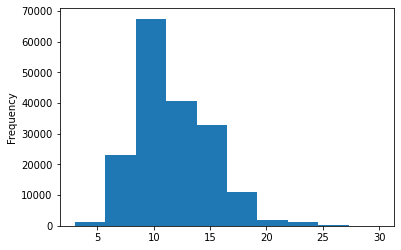

In [21]:
# Check the length of different lines

train_df.total_lines.plot.hist()

We see that most samples are of approx 10 lines 

### Get lists of sentences

In [22]:
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [23]:
# View the generated lines of sentences

train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### Convert the text based labels to numeric ones

In [24]:
# One hot encode the labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)   # to return an array

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))   # fit_transform only once, then transform
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot[:1], val_labels_one_hot[:1], test_labels_one_hot[:1]

(array([[0., 0., 0., 1., 0.]]),
 array([[1., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.]]))

In [25]:
# Label encode the labels

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded[:1], val_labels_encoded[:1], test_labels_encoded[:1]

(array([3]), array([0]), array([0]))

In [26]:
# Get the class names from the label encoder

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Start a series of Modelling Experiments

### Model 0: Create a baseline model

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(
    X = train_sentences,
    y = train_labels_encoded    # use label encoded and not one hot encoded, because it is not supported
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate the baseline odel on validation data

model_0.score(
    X= val_sentences,
    y=val_labels_encoded
)

0.7218323844829869

In [29]:
# Make predictions using our baseline model

baseline_preds = model_0.predict(val_sentences)
baseline_preds


array([4, 1, 3, ..., 4, 4, 1])

Calculate baseline results from the calculate_results function in our helper script

In [31]:
from helper_functions import calculate_results

baseline_result = calculate_results(y_true=val_labels_encoded, y_pred= baseline_preds)

baseline_result

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Prepare the text for deep sequence models by creating vectorization and embedding layers

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [33]:
# How long is each sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

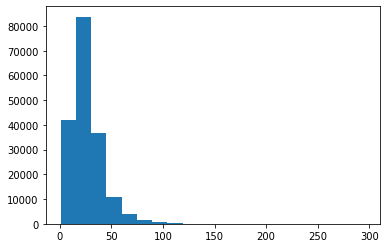

In [34]:
# What is the distribution of the text?

import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=20);

In [35]:
# How long of a sentence length covers 95% of examples

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

This means that sentences which are under 55 words shape 95% of the data

In [36]:
# What is the maximum sequence length in the training set?
max(sent_lens)

296

In [37]:
# Create a text vectorization layer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# How many words are in the vocab of the data?
max_tokens = 68000   # based on the paper im implementing

# Create the text vectorizer
text_vectorizer = TextVectorization(
    max_tokens= max_tokens,                     # number of words in the vocab
    output_sequence_length= output_seq_len      # desired output length of the sentences
)

In [38]:
# Adapt the text vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [39]:
# Test out the text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)

# Output the result
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
statistically significant differences were found in contrast sensitivity between the two types of correction for distance ( under mesopic conditions ) and for near vision , with the cbmclc exhibiting better results in both cases ( p < @ ) .

Length of text: 240

Vectorized text: [[  232    37   102     9   208     5   780   509    30     2    51  1086
      4  2055    11  1167   353 15768   458     3    11  2877  1922     7
      2 21016  9991   252   117     5    54   263    14     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [40]:
# How many words in our training vocab

text_vocab = text_vectorizer.get_vocabulary()

# Output the result
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in the vocab: {text_vocab[:5]}")
print(f"Least common words in the vocab: {text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# Create the embedding layer

from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim= len(text_vocab),
                        output_dim=128,
                        mask_zero=True,  # to handle variable sequence length (saves space)
                        name="tokeb_embedding"
                        )


In [42]:
# An example of embedding

print(f"Sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {[embedded_sentence]}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 statistically significant differences were found in contrast sensitivity between the two types of correction for distance ( under mesopic conditions ) and for near vision , with the cbmclc exhibiting better results in both cases ( p < @ ) .

Sentence after vectorization (before embedding):
 [[  232    37   102     9   208     5   780   509    30     2    51  1086
      4  2055    11  1167   353 15768   458     3    11  2877  1922     7
      2 21016  9991   252   117     5    54   263    14     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding: 
 [<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.00643519,  0.00997281, -0.00242788, ..., -0.0406569 ,
         -0.00227179, -0.0260299 ],
        [-0.03015896, -0.04748043, -0.01086649, ..., -0.04361049,
          0.03450701,  0.03181089],
        [-0.04514898,  0.03290497, -0.0157642

### Creating datasets (making sure the data loads faster)

In [43]:
# Turn the data into TensorFlow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, val_dataset, test_dataset

(<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [44]:
# Turn these datasets into prefetch datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # not shuffling now, since order is important
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Model 1: Conv1D with token embedding

In [45]:
# Create the model

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# compile the model

model_1.compile(
    loss= "categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics= ["accuracy"]
)

In [46]:
# Get an overview of the model

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 tokeb_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [47]:
# Fit the model

history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch= (0.1 * len(train_dataset)),    # to speed up fitting
    epochs=3,
    validation_data = val_dataset,
    validation_steps= int(0.1 * len(val_dataset))   # to speed up fitting
)

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.9196 - accuracy: 0.6330 - val_loss: 0.6849 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6570 - accuracy: 0.7557 - val_loss: 0.6326 - val_accuracy: 0.7636
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6189 - accuracy: 0.7750 - val_loss: 0.5970 - val_accuracy: 0.7846


In [48]:
# Evaluate on the validation dataset

model_1.evaluate(val_dataset)


945/945 [==============================] - 3s 3ms/step - loss: 0.5986 - accuracy: 0.7854


[0.5985676646232605, 0.7854163646697998]

In [49]:
# Make prediction
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[3.9981389e-01, 1.8055466e-01, 7.8057341e-02, 3.2294729e-01,
         1.8626807e-02],
        [4.7601020e-01, 2.2767726e-01, 1.0050247e-02, 2.7932128e-01,
         6.9410298e-03],
        [1.2561217e-01, 6.1924439e-03, 8.1305351e-04, 8.6734807e-01,
         3.4343735e-05],
        ...,
        [2.3822950e-06, 1.0287722e-03, 8.2051387e-04, 3.8146409e-06,
         9.9814451e-01],
        [5.5536307e-02, 4.3795443e-01, 1.1020163e-01, 7.9818793e-02,
         3.1648880e-01],
        [2.3285319e-01, 6.2602317e-01, 5.6389093e-02, 3.4729347e-02,
         5.0005253e-02]], dtype=float32), (30212, 5))

In [50]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [51]:
# Calculate results of model_1
model_1_result = calculate_results(
    y_true= val_labels_encoded,
    y_pred= model_1_preds
)

model_1_result

{'accuracy': 78.54163908380775,
 'f1': 0.7830387757770575,
 'precision': 0.7821026805026697,
 'recall': 0.7854163908380776}

In [52]:
# Compare it with the baseline model

baseline_result

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

We can see that our first model is doing way better than the baseline. This is good news!! Lets try transfer learning and see if it beats our model_1

### Model 2: Feature Extraction with pretrained token embeddings

Now we get the pretrained token embeddings from tensorflow hub

In [53]:
# Although the paper used GloVe embeddings, I will implement it using the USE encoder.

import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="USE_encoder")

In [54]:
# Test the pretrained embedding on a random sentence

random_train_sentence = random.choice(train_sentences)

# Output the results

print(f"Random sentences:\n {random_train_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedding_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedding_sentence[0])}")

Random sentences:
 the edinburgh postnatal depression scale ( epds ) and pittsburgh sleep quality index ( psqi ) were employed to evaluate depression and sleep quality , respectively .
Sentence after embedding:
[ 0.02037832 -0.0686217   0.02761592 -0.03782979 -0.0106076   0.06082975
 -0.06342603  0.02166366  0.01938502  0.02776537  0.05998522  0.07035717
 -0.01289119  0.04034748  0.07262176 -0.04788763 -0.07255524 -0.01312608
 -0.02451731  0.02565354  0.0635021   0.04994633  0.04606268  0.06519826
  0.00538946 -0.00658307  0.01283964  0.05459264  0.0682063   0.0248063 ]

Length of sentence embedding: 512


In [55]:
# Create the model

inputs = layers.Input(shape=([]), dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_2_USE_encoder")

# compile the model

model_2.compile(
    loss= "categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics= ["accuracy"]
)

In [56]:
# Get the summary
model_2.summary()

Model: "model_2_USE_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE_encoder (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [57]:
# Fit the model

history_model_2 = model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch= (0.1 * len(train_dataset)),
    validation_data= val_dataset,
    validation_steps= int(0.1 * len(val_dataset))
)

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9193 - accuracy: 0.6489 - val_loss: 0.7983 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7670 - accuracy: 0.7035 - val_loss: 0.7504 - val_accuracy: 0.7088
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7463 - accuracy: 0.7148 - val_loss: 0.7318 - val_accuracy: 0.7118


In [58]:
# Evaluate on the validation set

model_2.evaluate(val_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7352 - accuracy: 0.7173


[0.7352218627929688, 0.7172977328300476]

In [59]:
# Make predictions
model_2_pred_probs = model_2.predict(val_dataset)
model_1_pred_probs

array([[3.9981389e-01, 1.8055466e-01, 7.8057341e-02, 3.2294729e-01,
        1.8626807e-02],
       [4.7601020e-01, 2.2767726e-01, 1.0050247e-02, 2.7932128e-01,
        6.9410298e-03],
       [1.2561217e-01, 6.1924439e-03, 8.1305351e-04, 8.6734807e-01,
        3.4343735e-05],
       ...,
       [2.3822950e-06, 1.0287722e-03, 8.2051387e-04, 3.8146409e-06,
        9.9814451e-01],
       [5.5536307e-02, 4.3795443e-01, 1.1020163e-01, 7.9818793e-02,
        3.1648880e-01],
       [2.3285319e-01, 6.2602317e-01, 5.6389093e-02, 3.4729347e-02,
        5.0005253e-02]], dtype=float32)

In [60]:
# Convert the prediction probabilities to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [61]:
# Calculate the results of model2

model_2_result = calculate_results(
    y_true= val_labels_encoded,
    y_pred=model_2_preds
)

model_2_result

{'accuracy': 71.72977624784855,
 'f1': 0.7145320290178109,
 'precision': 0.7178822114983138,
 'recall': 0.7172977624784854}

In [62]:
# Compare it with our so far best model: model 1

model_1_result

{'accuracy': 78.54163908380775,
 'f1': 0.7830387757770575,
 'precision': 0.7821026805026697,
 'recall': 0.7854163908380776}

We see that this mode, model_2, is doing so poorly compared to model 1. Lets try another way

### Model 3: Conv1D with character embeddings

Instead of word tokenizer, Ill try character level tokenization

In [63]:
# Make function to split sentences into characters

def split_chars(text):
    return " ".join(list(text))

In [64]:
split_chars(random_train_sentence)

't h e   e d i n b u r g h   p o s t n a t a l   d e p r e s s i o n   s c a l e   (   e p d s   )   a n d   p i t t s b u r g h   s l e e p   q u a l i t y   i n d e x   (   p s q i   )   w e r e   e m p l o y e d   t o   e v a l u a t e   d e p r e s s i o n   a n d   s l e e p   q u a l i t y   ,   r e s p e c t i v e l y   .'

In [65]:
# Split sequence level data splits into character level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# Apply it to the other categories

val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [67]:
# What is the average char length?

char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

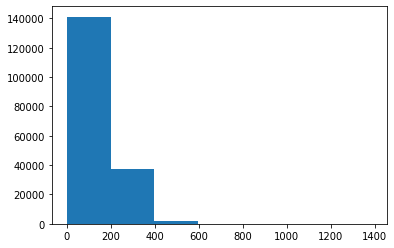

In [68]:
# Check the distribution

plt.hist(char_lens, bins=7);

In [69]:
# Find what char length covers 95% of sequences

output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [70]:
# Get all keyboard characters

random.choice(train_sentences)

'continuation of compressions caused a prolongation in intubation times for both the i-gel ( p < @ ) and the ilma ( p < @ ) .'

In [71]:
# Get the keyboard chars from the string library
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# Create char level token vectorizer instance

NUM_CHAR_TOKENS = len(alphabet) + 2     # added 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [73]:
# Adapt the char vectorization to training characters
char_vectorizer.adapt(train_chars)

In [74]:
# Check the char vocab
char_vocab = char_vectorizer.get_vocabulary()

# Output the results

print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common chars: {char_vocab[:5]}")
print(f"5 least common chars: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common chars: ['', '[UNK]', 'e', 't', 'i']
5 least common chars: ['k', 'x', 'z', 'q', 'j']


In [75]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
w e   s t u d i e d   t h e   m e t a b o l i c   r e s p o n s e   t o   a   h i g h e r   o r   l o w e r   p r o t e i n   s u p p l y   i n   i n f a n c y   .

Length of chars: 68

Vectorized chars:
[[20  2  9  3 16 10  4  2 10  3 13  2 15  2  3  5 22  7 12  4 11  8  2  9
  14  7  6  9  2  3  7  5 13  4 18 13  2  8  7  8 12  7 20  2  8 14  8  7
   3  2  4  6  9 16 14 14 12 19  4  6  4  6 17  5  6 11 19  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0

In [76]:
# Create a character level embedding

char_embed = Embedding(
    input_dim=len(char_vocab),
    output_dim=25,  # the size of the char embedding from the paper
    mask_zero=True,
    name="char_embed")

In [77]:
# Test out character embedding layer

print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}")
print(f"Characater embedding shape: {char_embed_example.shape}")

Charified text:
 w e   s t u d i e d   t h e   m e t a b o l i c   r e s p o n s e   t o   a   h i g h e r   o r   l o w e r   p r o t e i n   s u p p l y   i n   i n f a n c y   .

Embedded chars. (after vectorization and embedding):
 [[[ 0.01244389  0.02135349  0.02854614 ...  0.03587915  0.00415332
    0.00593624]
  [ 0.02956272 -0.02322036 -0.03614338 ... -0.04738186  0.00062203
    0.00798547]
  [-0.02473824  0.02148184  0.00767943 ...  0.0399888   0.03585869
   -0.03668563]
  ...
  [ 0.0132109   0.01844755  0.01332058 ...  0.01272574  0.02306009
    0.01305684]
  [ 0.0132109   0.01844755  0.01332058 ...  0.01272574  0.02306009
    0.01305684]
  [ 0.0132109   0.01844755  0.01332058 ...  0.01272574  0.02306009
    0.01305684]]]
Characater embedding shape: (1, 290, 25)


In [78]:
# Create the model

inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorizer_layer = char_vectorizer(inputs)
char_embeddding_layer = char_embed(char_vectorizer_layer)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddding_layer)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embedding")

# Compile the model

model_3.compile(
    loss= "categorical_crossentropy",
    optimizer= tf.optimizers.Adam(),
    metrics= ["accuracy"]
)

In [79]:
# Get the summary of the model

model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [80]:
# Create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Fit the model

history_model_3 = model_3.fit(
    train_char_dataset,
    epochs=3,
    steps_per_epoch= (0.1 * len(train_char_dataset)),
    validation_data= val_char_dataset,
    validation_steps= int(0.1 * len(val_dataset))
)

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2575 - accuracy: 0.4890 - val_loss: 1.0337 - val_accuracy: 0.5844
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9968 - accuracy: 0.6028 - val_loss: 0.9318 - val_accuracy: 0.6410
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9229 - accuracy: 0.6404 - val_loss: 0.8673 - val_accuracy: 0.6679


**Note:** Using Average Pooling resulted in `val_accuracy: 0.4461`, however using Max Pooling got us `val_accuracy: 0.6602`

In [82]:
# Make predictions with character model only

model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.15924557, 0.31592587, 0.14522569, 0.27535015, 0.10425275],
       [0.27344474, 0.5056458 , 0.01274878, 0.11332849, 0.0948322 ],
       [0.11093859, 0.33275422, 0.2158021 , 0.18333466, 0.15717037],
       ...,
       [0.02137451, 0.04175682, 0.11085238, 0.03580321, 0.79021305],
       [0.02586662, 0.13029493, 0.25219455, 0.06621025, 0.52543366],
       [0.29945332, 0.534296  , 0.06516439, 0.08537427, 0.01571204]],
      dtype=float32)

In [83]:
# Convert prediction probabilities to class labels

model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [84]:
# Calculate results for the model

model_3_result = calculate_results(
    y_true= val_labels_encoded,
    y_pred= model_3_preds
)

model_3_result

{'accuracy': 65.80166821130676,
 'f1': 0.6459058076419392,
 'precision': 0.6541708022609578,
 'recall': 0.6580166821130676}

Looks like this is performing at an all time low. Lets compare it to model_1

In [85]:
model_1_result

{'accuracy': 78.54163908380775,
 'f1': 0.7830387757770575,
 'precision': 0.7821026805026697,
 'recall': 0.7854163908380776}

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid model)

In [86]:
# Set up the token inputs/model

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)

token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

In [87]:
# Setup char inputs/model

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)   # from the paper

char_model = tf.keras.Model(
    inputs= char_inputs,
    outputs= char_bi_lstm
)

In [88]:
# Concatenate token and char outputs

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [89]:
# Create the output layers - adding in Dropout, as in the paper

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [90]:
# Finally create the model

model_4 = tf.keras.Model(
    inputs= [token_model.inputs, char_model.inputs],
    outputs= output_layer,
    name="model_4_hybrid"
)

In [91]:
# get the summary

model_4.summary()

Model: "model_4_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE_encoder (KerasLayer)       (None, 512)          256797824   ['token_input[0][0]'

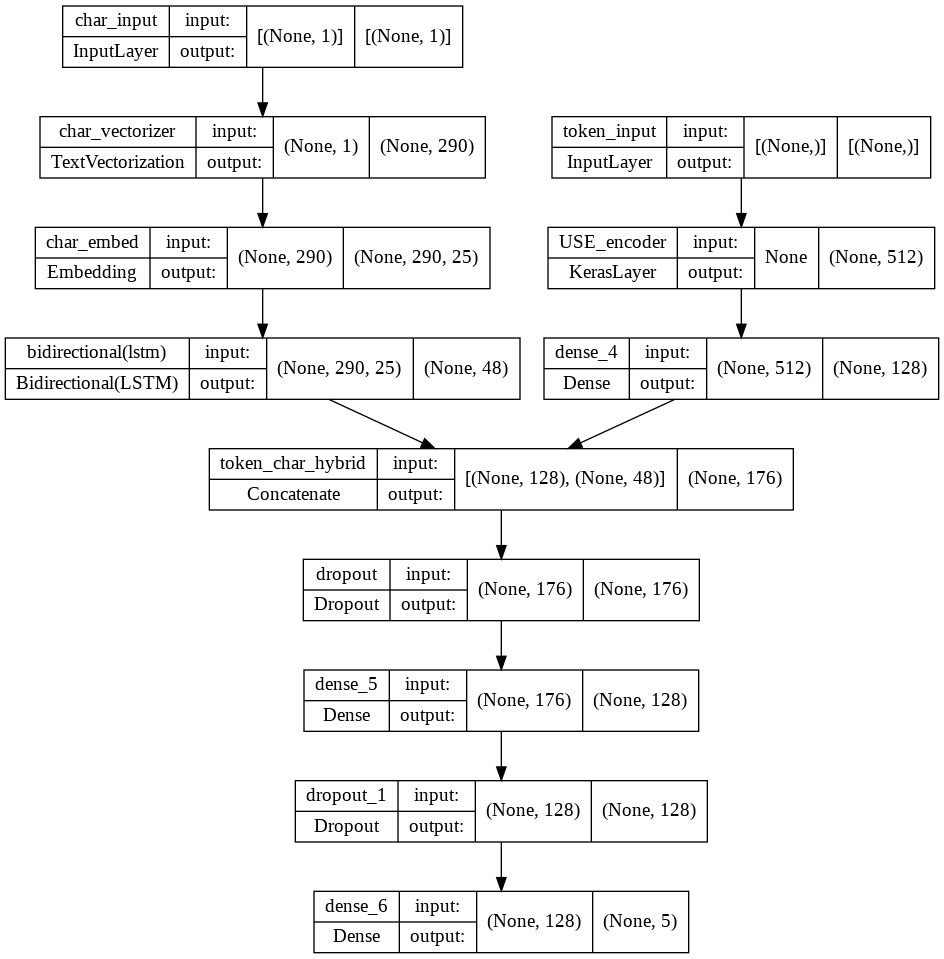

In [92]:
# Plot the hybrid model to help visualize such model

from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes=True)

In [93]:
# Compile the model

model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),    # the paper states SGD, however, Ill try it with Adam
    metrics=["accuracy"]
)

In [94]:
# Combine chars and tokens into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

In [95]:
# Create prefetch and apply batch size

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
# Perform the same creation for both val and test data

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [98]:
# Fit the model

history_model_4 = model_4.fit(
    train_char_token_dataset,
    epochs=3,
    steps_per_epoch= (0.1 * len(train_char_token_dataset)),
    validation_data= val_char_token_dataset,
    validation_steps= int(0.1 * len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 41s 56ms/step - loss: 0.9833 - accuracy: 0.6108 - val_loss: 0.7961 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.8042 - accuracy: 0.6900 - val_loss: 0.7175 - val_accuracy: 0.7267
Epoch 3/3
562/562 [==============================] - 26s 47ms/step - loss: 0.7765 - accuracy: 0.7038 - val_loss: 0.6854 - val_accuracy: 0.7374


In [99]:
# Evaluate on the val dataset

model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 25s 26ms/step - loss: 0.6908 - accuracy: 0.7354


[0.6908285021781921, 0.7353700399398804]

In [100]:
# Make predictions using the hybrid model

model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.4144258e-01, 3.5307410e-01, 4.8170318e-03, 1.8963246e-01,
        1.1033821e-02],
       [2.9779413e-01, 5.3882134e-01, 5.3106905e-03, 1.5523285e-01,
        2.8410358e-03],
       [3.0411831e-01, 1.9397098e-01, 6.7999117e-02, 3.7141842e-01,
        6.2493116e-02],
       ...,
       [6.0818996e-04, 1.0829273e-02, 5.3612594e-02, 1.8950454e-04,
        9.3476039e-01],
       [6.3365400e-03, 6.6870466e-02, 2.2670174e-01, 2.5378289e-03,
        6.9755346e-01],
       [2.8109029e-01, 3.9071086e-01, 2.6686200e-01, 3.1335078e-02,
        3.0001797e-02]], dtype=float32)

In [101]:
# Convert the predicition probabilities to prediction labels

model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [102]:
# Calculate the results of the model

model_4_result = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_4_preds
)

model_4_result

{'accuracy': 73.53700516351118,
 'f1': 0.7320964895337477,
 'precision': 0.7365913681016637,
 'recall': 0.7353700516351118}

In [103]:
# Compare it with our top performing model

model_1_result

{'accuracy': 78.54163908380775,
 'f1': 0.7830387757770575,
 'precision': 0.7821026805026697,
 'recall': 0.7854163908380776}

Still not better than model 1, however, we are on the right track

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

Ill use the engineered features made availabel in the dictionary of samples to be able to use positional embeddings.


These features are `line number` and `total lines`

In [104]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

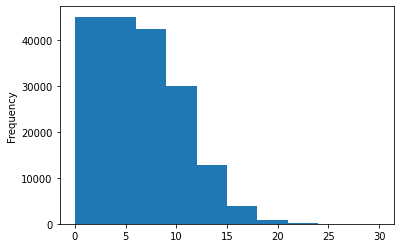

In [105]:
# Check the distribution of line number column

train_df.line_number.plot.hist()

Lets encode the line number column using tensorflow's one hot encode

In [106]:
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [107]:
# Perform the same encoding to val and test data

val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=15)

In [108]:
# Perform the same steps to the feature total lines

# Get the total lines count

train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

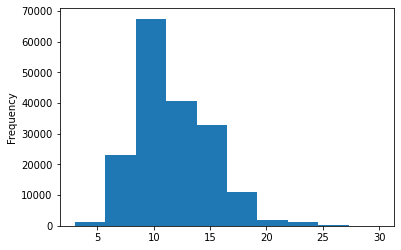

In [109]:
# See what the distribution look like for total lines

train_df["total_lines"].plot.hist()

In [110]:
# Encode the total lines feature

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [111]:
# Perform the same encoding to val and test data

val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

Time to create the models that will be concatenated into a whole model

Since we made the previous 2 models, `token_model` and `char_model`, and concatenated them into `token_char_concat` layer, we will only need to build the models for the 2 feature engineered properties. However, I have rebuilt again for readability.

In [112]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [113]:
# Get a summary of this huge model

model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE_encoder (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]']     

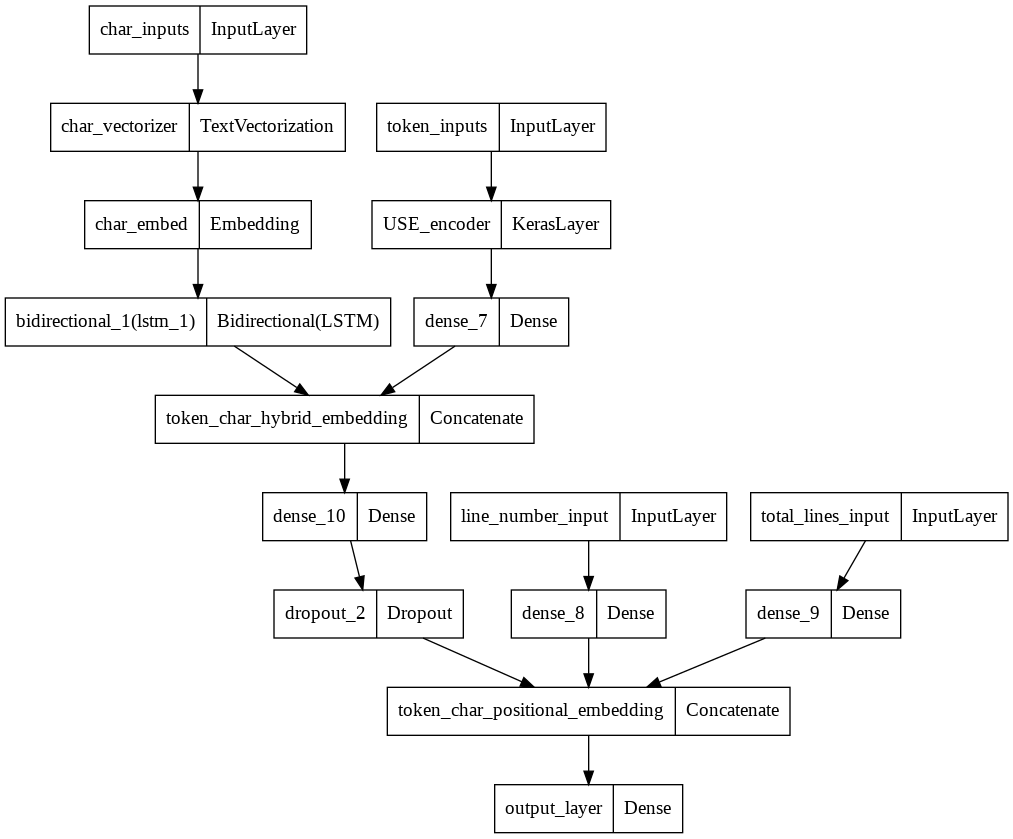

In [114]:
# Plot the model architecture to understand its complexities

tf.keras.utils.plot_model(model_5, )

Great! We can now proceed with compiling it

In [115]:
model_5.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),     # helps avoid overfitting (label_smoothing)
    optimizer= tf.keras.optimizers.Adam(),
    metrics=["accuracy"] 
)

Now, we need to prepare new datasets for model_5 before fitting it

In [116]:

train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot, 
                                                                train_sentences, 
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [117]:
# Output the results

train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [118]:
# Finally, fit the model

history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 57ms/step - loss: 1.0956 - accuracy: 0.7220 - val_loss: 0.9799 - val_accuracy: 0.8035
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.9658 - accuracy: 0.8143 - val_loss: 0.9459 - val_accuracy: 0.8308
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9485 - accuracy: 0.8237 - val_loss: 0.9360 - val_accuracy: 0.8361


In [119]:
# Make predictions
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

array([[0.52422297, 0.10704228, 0.01153375, 0.33679056, 0.02041042],
       [0.57535017, 0.07873467, 0.04885192, 0.289009  , 0.00805415],
       [0.30874217, 0.10037199, 0.12726565, 0.39999545, 0.06362469],
       ...,
       [0.03985813, 0.09704975, 0.03613631, 0.03480103, 0.7921548 ],
       [0.03080122, 0.35213673, 0.08260725, 0.02784631, 0.5066085 ],
       [0.17484467, 0.60100925, 0.11941972, 0.0398751 , 0.06485124]],
      dtype=float32)

In [120]:
# Convert the probabilities to labels

model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [121]:
# Calculate the results of model 5

model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.57606249172514,
 'f1': 0.8347327369617654,
 'precision': 0.8345434052852637,
 'recall': 0.8357606249172514}

We can see that this model outperforms our previously best model, namely `model_1`.

With an astonishing accuracy of **83.57%**.

> Even though the paper I tried to implement got an accuracy of around 90% for this model, there were various factors that I either skipped or changed or even tried my own way. Overall, it was a great experience.